<img src="./logo_UTN.svg" align="right" width="150" /> 
#### Procesamiento Digital de Señales

# Trabajo Semanal Nº9
#### Nicolás Salvia

# TS9: Estimación espectral a prueba: Ancho de banda del Electrocardiograma.
En esta tarea realizaremos el punto 4 del TP4

4) En el archivo ECG_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación: 
- Ruido causado por el movimiento de los electrodos (Alta frecuencia)
- Ruido muscular (Alta frecuencia)
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia)

Ayuda: Los latidos presentes en el registro de ECG, alineados y clasificados (de origen normal y ventricular) poseen las siguientes características temporales y frecuenciales: 

- ecg_lead: Registro de ECG muestreado a $fs=1$ KHz durante una prueba de esfuerzo
- qrs_pattern1: Complejo de ondas QRS normal
- heartbeat_pattern1: Latido normal
- heartbeat_pattern2: Latido de origen ventricular
- qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal as scpySig
import pandas as pd

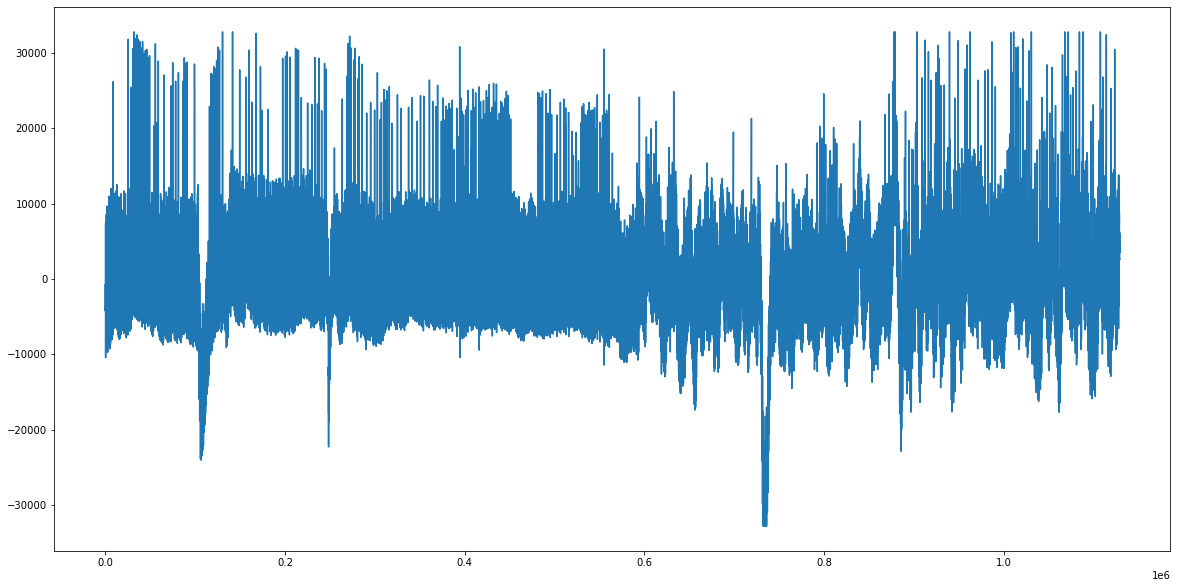

In [2]:
# Cargamos y graficamos la señal original
plt.rcParams['figure.figsize'] = [20, 10]

mat = scipy.io.loadmat('TP4/ECG_TP4.mat')

ecg_lead = mat.get('ecg_lead')
heartbeat_pattern1 = mat.get('heartbeat_pattern1')
heartbeat_pattern2 = mat.get('heartbeat_pattern2')
qrs_detections = mat.get('qrs_detections')
qrs_pattern1 = mat.get('qrs_pattern1')

plt.plot(ecg_lead);

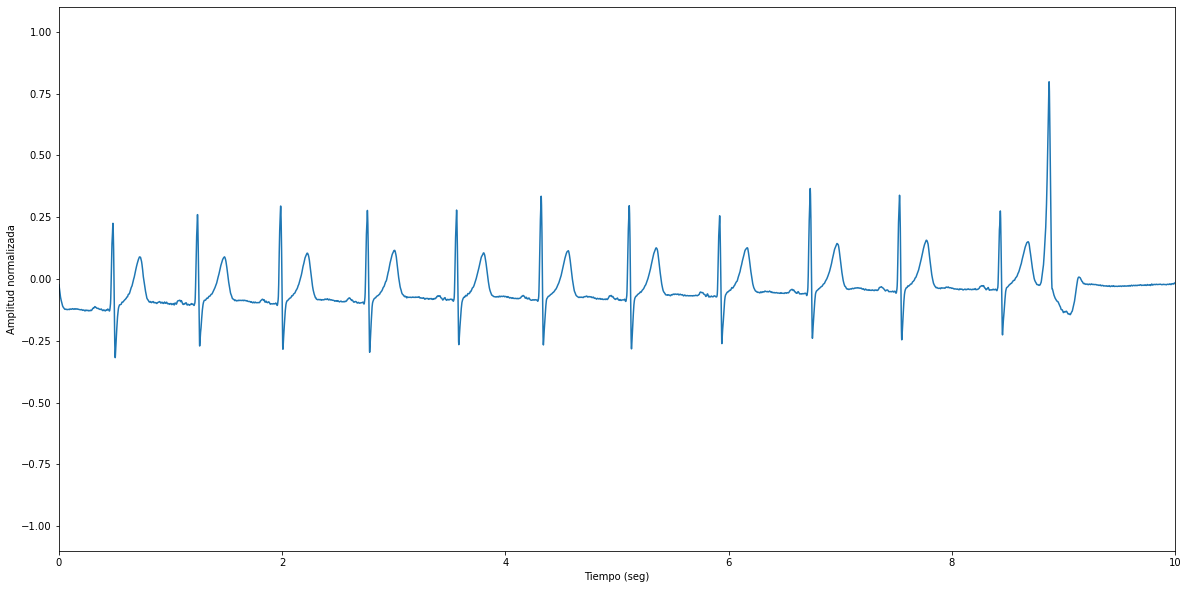

In [3]:
# Normalizamos la señal y acotamos el gráfico
fs = 1000
N = ecg_lead.shape[0]
ts = 1/fs
tt = np.linspace(0, (N-1)*ts, N).flatten()

ecg_lead_normalize = ecg_lead/ecg_lead[np.argmax(ecg_lead)]
plt.plot(tt, ecg_lead_normalize)
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (seg)')
plt.xlim([0, 10]);

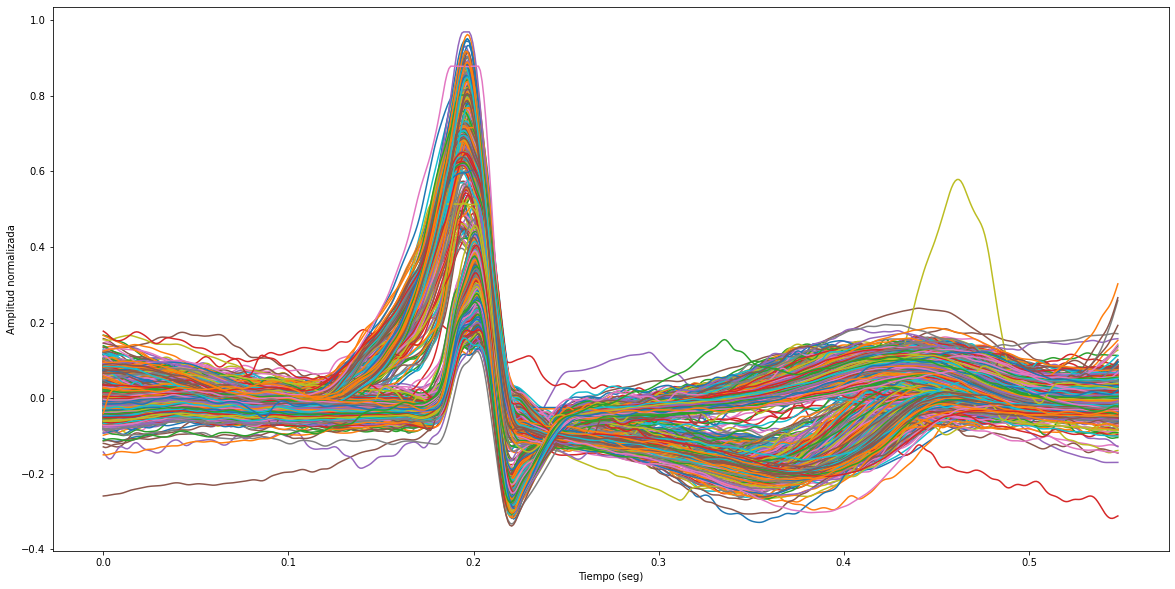

In [17]:
# Agrupamos todos los latidos y los graficamos
N_periodo = int(round(0.200/ts))
tt_latidos = np.linspace(0, (2*(N_periodo-1)+150)*ts, 2*N_periodo+150).flatten()

ecg_matrix = np.hstack([(ecg_lead_normalize[int(ii-N_periodo):int(ii+N_periodo)+150]) for ii in qrs_detections ])
ecgMatrixNormalized = ecg_matrix - np.mean(ecg_matrix, axis=0) 
plt.plot(tt_latidos, ecgMatrixNormalized)
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (seg)');

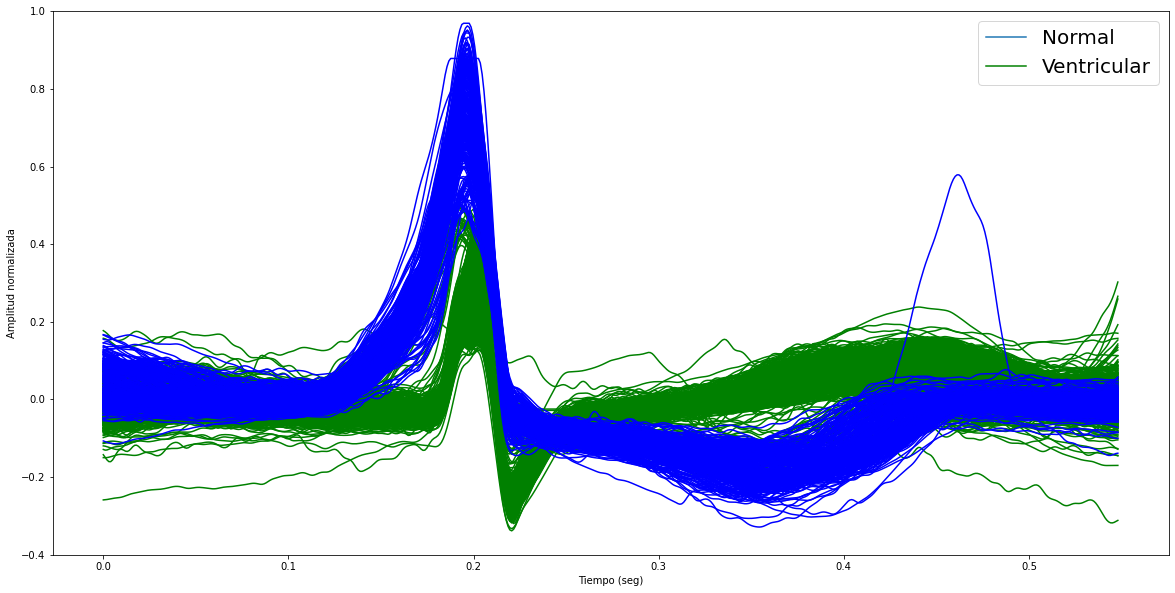

In [18]:
# Separamos los tipos de pulsos a definiendo un límite de amplitud para reconocer uno u otro
ampThreshold = 0.5
ventricularArray = []
normalArray = []

for k in range(len(ecgMatrixNormalized[0])):
    if np.max(ecgMatrixNormalized[:,k]) > 0.5:
        ventricularArray.append(ecgMatrixNormalized[:,k])
    else:
        normalArray.append(ecgMatrixNormalized[:,k])

# Convertimos la lista en una matrix        
ventricularArray = np.squeeze(ventricularArray)
normalArray = np.squeeze(normalArray)

#Invertimos filas con columnas
ventricularArray = ventricularArray.transpose()
normalArray = normalArray.transpose()

#Graficamos
plt.plot(2)
plt.plot(tt_latidos, normalArray, 'g')
plt.plot(tt_latidos, ventricularArray, 'b')
plt.ylim([-0.4, 1])
plt.legend(['Normal', 'Ventricular'], prop={'size': 20})
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (seg)');

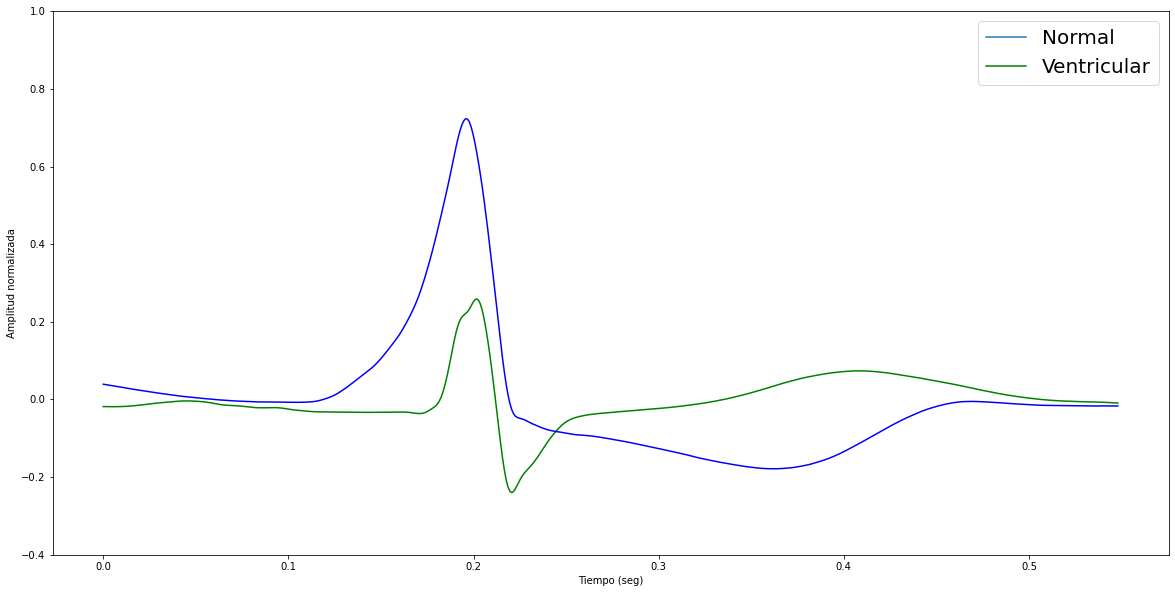

In [19]:
# Graficamos las medias de ambos pulsos
ventricularMean = np.mean(ventricularArray, axis=1)
normalMean = np.mean(normalArray, axis=1)

#Graficamos
plt.plot(2)
plt.plot(tt_latidos, normalMean, 'g')
plt.plot(tt_latidos, ventricularMean, 'b')
plt.ylim([-0.4, 1])
plt.legend(['Normal', 'Ventricular'], prop={'size': 20})
plt.ylabel('Amplitud normalizada')
plt.xlabel('Tiempo (seg)');

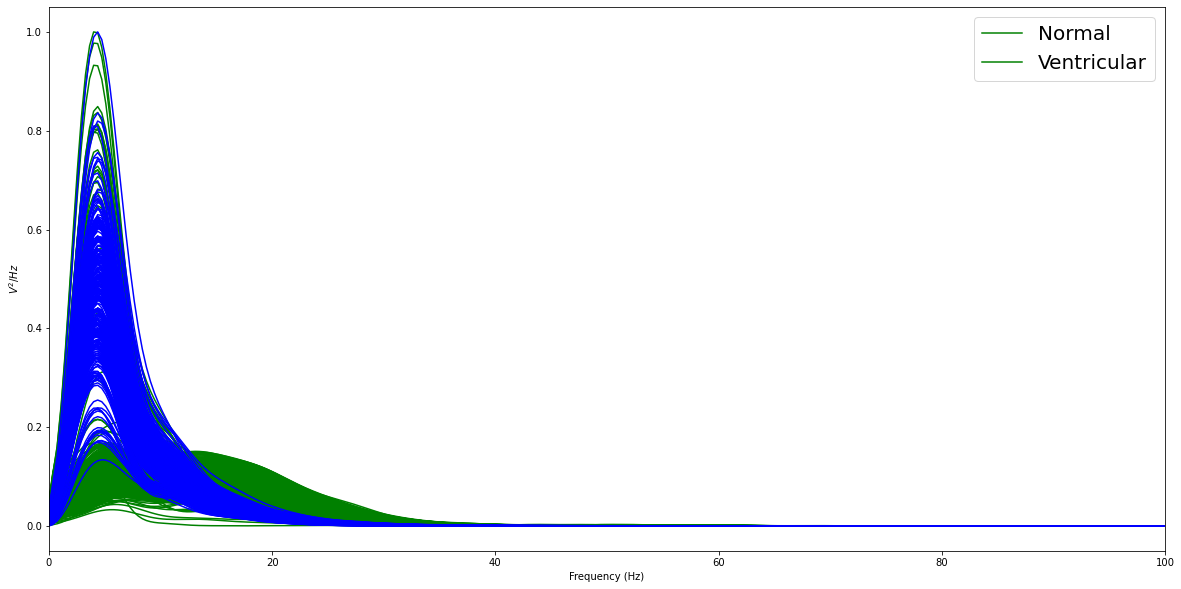

In [31]:
#Graficamos el periodograma de ambas señales

ff, ventricularPeriodogram = scpySig.welch(ventricularArray, fs, window='hann', nfft = 5*len(ventricularArray), axis = 0)
ff, normalPeriodogram = scpySig.welch(normalArray, fs, window='hann', nfft = 5*len(normalArray), axis = 0)

plt.figure(2)
plt.plot(ff, normalPeriodogram/np.max(normalPeriodogram), 'g')
plt.plot(ff, ventricularPeriodogram/np.max(ventricularPeriodogram), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('$V^2/Hz$')
plt.legend(['Normal', 'Ventricular'], prop={'size': 20})
plt.xlim([0,100]);

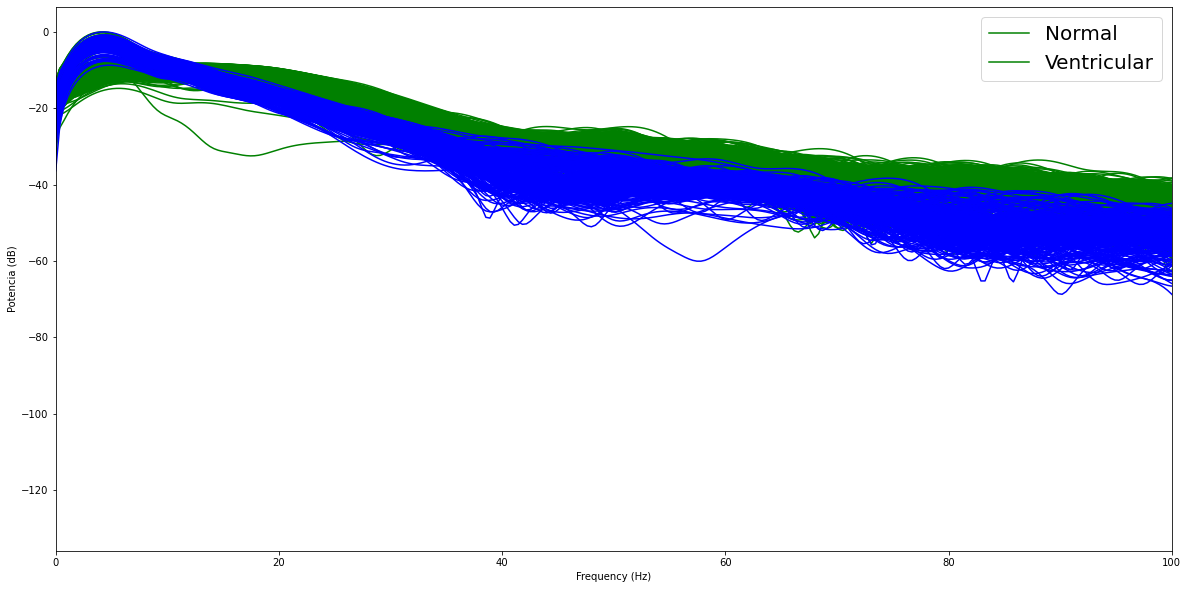

In [29]:
# Graficamos en dB

plt.figure(3)
plt.plot(ff, 10*np.log10(normalPeriodogram/np.max(normalPeriodogram)), 'g')
plt.plot(ff, 10*np.log10(ventricularPeriodogram/np.max(ventricularPeriodogram)), 'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Potencia (dB)')
plt.legend(['Normal', 'Ventricular'], prop={'size': 20})
plt.xlim([0,100]);

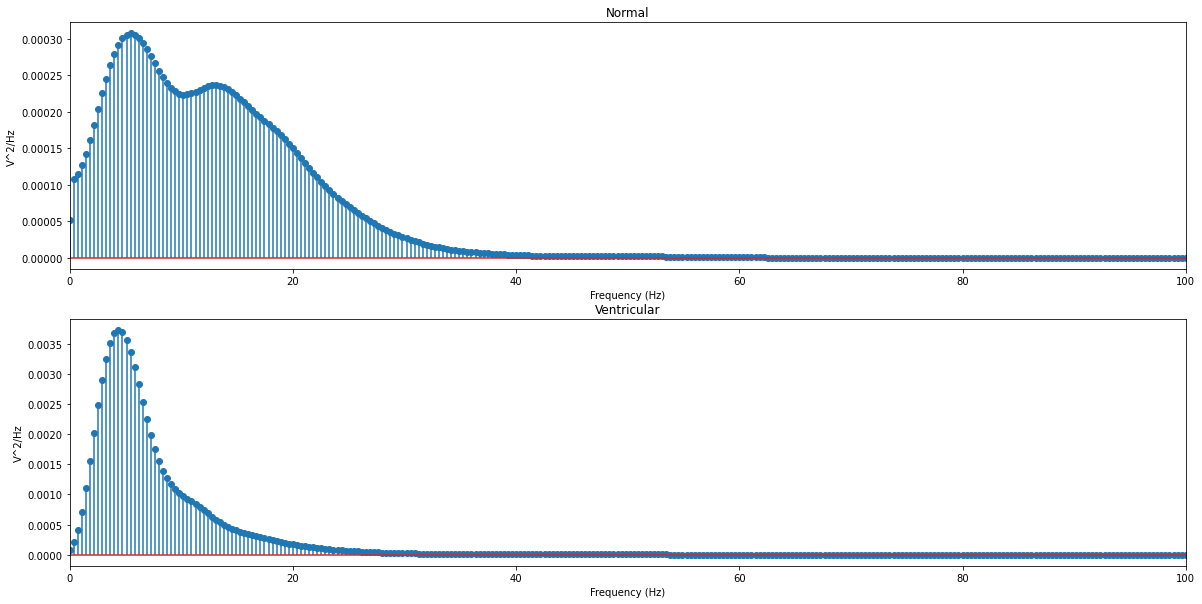

In [59]:
# Calculo la media de ambas señales y graficamos
normalPeriodogramMean = np.mean(normalPeriodogram, axis=1)
ventricularPeriodogramMean = np.mean(ventricularPeriodogram, axis=1)

fig, [normal, ventricular] = plt.subplots(2)
normal.stem(ff, normalPeriodogramMean)
normal.set(xlabel='Frequency (Hz)', ylabel='V^2/Hz')
normal.set_title('Normal')
normal.set_xlim([0,100]);

ventricular.stem(ff, ventricularPeriodogramMean)
ventricular.set(xlabel='Frequency (Hz)', ylabel='V^2/Hz')
ventricular.set_title('Ventricular')
ventricular.set_xlim([0,100]);

In [68]:
#Calculamos en que banda de frecuencia se concentra el 90% de la potencia de la señal

## Calculamos las potencias totales
PotTotalNormal = np.sum(normalPeriodogramMean)
PotTotalVentricular = np.sum(ventricularPeriodogramMean)

indexNormal = 0
indexVentricular = 0
indexStopNormal = 0

PotCursor = 0
for k in range(len(ff)):
    PotCursor += normalPeriodogramMean[k+5]
    if(PotCursor >= 0.9*PotTotalNormal):
        indexNormal = k+5
        break

for k in range(len(ff)):
    PotCursor += ventricularPeriodogramMean[k+5]
    if(PotCursor >= 0.9*PotTotalVentricular):
        indexVentricular = k+5
        break
        
PotCursor = 0
for k in range(len(ff)):
    PotCursor += normalPeriodogramMean[k+5]
    if(PotCursor >= 0.95*PotTotalNormal):
        indexStopNormal = k+5
        break
        

data = [
        ['fs0',ff[2]],
        ['fc0',ff[5]],
        ['fc1',ff[indexNormal]],
        ['fs1',ff[indexStopNormal]]
       ]
df = pd.DataFrame(data, columns=['Nombre', 'Frecuencia[HZ]'])
df

,Nombre,Frecuencia[HZ]
0,fs0,0.727273
1,fc0,1.818182
2,fc1,26.181818
3,fs1,37.818182


Para separar los pulsos ventriculares de los pulsos normales, se establecio un límite de amplitud donde se clasifica al pulso como uno u otro según la amplitud máxima de la señal sobrepase ese límite. Para determinar las frecuencias, se calculo la potencia total y se busco la frecuencia a la cual se obtiene que la suma de la potencia alcanza el 90%. Para hallar la frecuencia donde debe comenzar la banda de detenida, se busco la frecuencia a la cual se obtiene que la suma de la potencia alcanza el 95% 